#  DCGAN 

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html mix with MINST dataset

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [16]:
# Root directory for dataset
dataroot = "/celeba"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28
# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#### MINST

In [17]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [18]:

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=workers,shuffle=True)

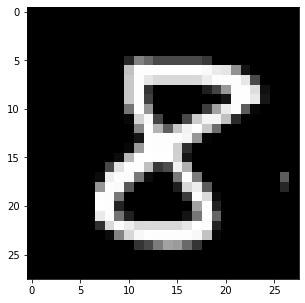

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

###  Weigth initialization 
Required to init the wwight with normal distribution , mean = 0, stdev = 0.02

In [20]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

###  Generator
Will trnasforme an input random vector to volume information

In [98]:
'''torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
H out=(Hin−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
W out=(W in −1)×stride[1]−2×padding[1]+dilation[1]×(kernel_size[1]−1)+output_padding[1]+1'''
dilatation = 1
output_padding = 0
kernel = 4
stride = 1
padding =0
Hin= 4
Win = 4
Ho = (Hin-1)*stride - (2*padding) + (dilatation*(kernel-1)) + output_padding +1
Wo = (Win-1)*stride - (2*padding) + (dilatation*(kernel-1)) + output_padding +1
print('Input:',Hin,'x',Win,'--> output:',Ho,'x',Wo)


Input: 4 x 4 --> output: 7 x 7


In [118]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu      
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #100x1x1 --> 224x4,4
            nn.ConvTranspose2d( nz, ngf * 8, kernel_size = 4, stride = 1, padding=0,bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            #224x4,4 --> 112x7x7
            nn.ConvTranspose2d( ngf * 8, ngf * 4, kernel_size = 4, stride = 1, padding=0,bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (112) x 7 x 7  --> 64x14x4
            nn.ConvTranspose2d(ngf * 4, ngf * 2,kernel_size=4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            #state size. (64) x 14 x 14  --> 1x28x28
            nn.ConvTranspose2d( 2*ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [119]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 224, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(56, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


### Discriminator
Binary classificator  take and image and output the probability of the image to be real

In [120]:
'''torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
Hout=[Hin+2×padding[0]−dilation[0]×(kernel_size[0]−1)−1]/stride[0] +1
WOut = [Win+2×padding[0]−dilation[0]×(kernel_size[0]−1)−1]/stride[0] +1'''
dilatation = 1
kernel = 4
stride = 2
padding = 1
Hin= 4
Win = 4
Ho = ( Hin + (2*padding) - (dilatation*(kernel-1)) -1)/stride  + 1
Wo = ( Win + (2*padding) - (dilatation*(kernel-1)) -1)/stride  + 1
print('Input:',Hin,'x',Win,'--> output:',Ho,'x',Wo)


Input: 4 x 4 --> output: 2.0 x 2.0


In [121]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (1) x 28 x 28  --> 112*14*14
            nn.Conv2d(nc, ndf*2, kernel_size = 4, stride= 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (112) x 14 x 14  --> 224 *7*7
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #112x7x7 -->224x4x4
            nn.Conv2d(ndf * 4, ndf*8, kernel_size= 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            #224x4x4 --> 1x1x1
            nn.Conv2d(ndf * 8, 1, kernel_size= 4, stride = 2, padding = 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [122]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(112, 224, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(224, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (9): Sigmoid()
  )
)


###  Loss function
Real labels = 1 , fake = 0
We will use BCELoss, 
One optimazer for the generator and one for discriminator

In [123]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [129]:
fixed_noise.shape

torch.Size([64, 100, 1, 1])

### Trainning
https://github.com/soumith/ganhacks

In this nootebok, train Discriminator with fake and real data, then train generator

In [124]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device).view(-1)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
     
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost this make for the negative simbol y the formula o max min
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.6054	Loss_G: 1.4902	D(x): 0.4874	D(G(z)): 0.5061 / 0.2595
[0/5][50/469]	Loss_D: 0.2333	Loss_G: 4.8818	D(x): 0.8976	D(G(z)): 0.1073 / 0.0091
[0/5][100/469]	Loss_D: 0.1519	Loss_G: 5.4521	D(x): 0.9395	D(G(z)): 0.0764 / 0.0061
[0/5][150/469]	Loss_D: 0.1954	Loss_G: 4.3124	D(x): 0.9425	D(G(z)): 0.1180 / 0.0195
[0/5][200/469]	Loss_D: 0.2275	Loss_G: 4.1889	D(x): 0.9452	D(G(z)): 0.1467 / 0.0210
[0/5][250/469]	Loss_D: 0.2749	Loss_G: 3.8003	D(x): 0.9106	D(G(z)): 0.1497 / 0.0308
[0/5][300/469]	Loss_D: 0.1312	Loss_G: 3.2106	D(x): 0.9357	D(G(z)): 0.0578 / 0.0498
[0/5][350/469]	Loss_D: 0.7217	Loss_G: 5.5978	D(x): 0.9742	D(G(z)): 0.4327 / 0.0081
[0/5][400/469]	Loss_D: 0.1315	Loss_G: 3.3930	D(x): 0.9239	D(G(z)): 0.0456 / 0.0448
[0/5][450/469]	Loss_D: 0.0796	Loss_G: 3.7074	D(x): 0.9710	D(G(z)): 0.0470 / 0.0348
[1/5][0/469]	Loss_D: 0.1638	Loss_G: 3.2515	D(x): 0.9549	D(G(z)): 0.1051 / 0.0510
[1/5][50/469]	Loss_D: 0.0803	Loss_G: 3.6405	D(x): 0.9512	D(G(z)): 

### Results

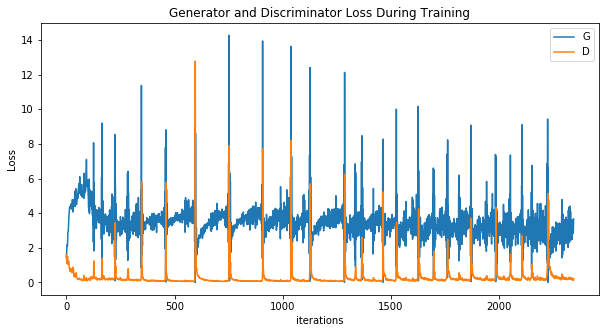

In [125]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Progression

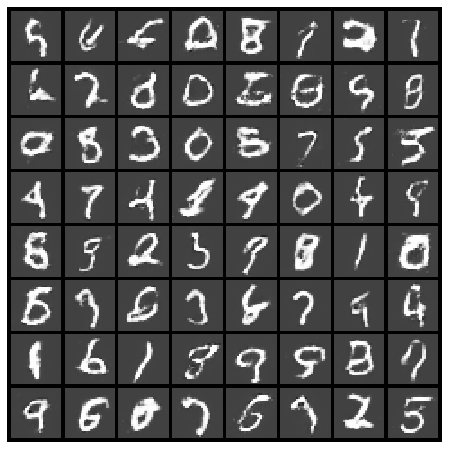

In [126]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

#### Real Vs Fake

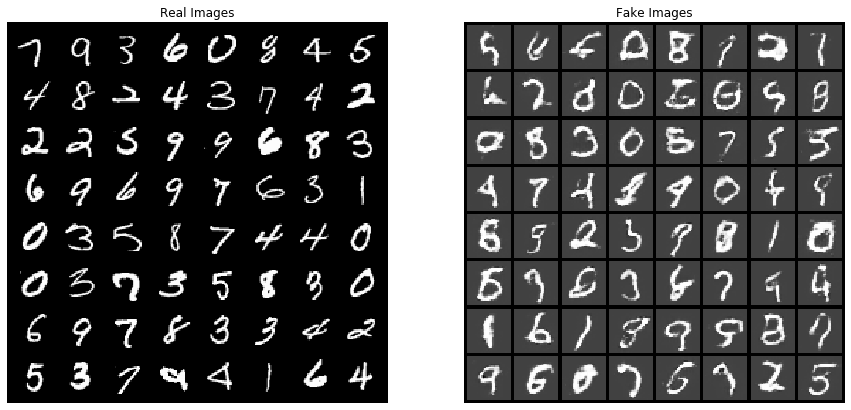

In [127]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

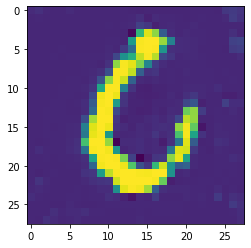

In [167]:
z_vector = torch.randn(1, nz, 1, 1, device=device)
fake = netG(z_vector).detach().cpu()
plt.imshow(fake[0].data.numpy()[-1])
plt.show()